I want to explore the relationship between binding energy and dynamic range. My theory is that fitness for inducible simple repression corresponds fairly directly with dynamic range. In order to think more cleverly about this idea, I want to develop a stronger understanding of how operator binding energy *alone* can affect dynamic range. 

I'll start with the dynamic range equations specified in our MWC paper:

\begin{equation} 
\mathrm{min} = \frac{1}{1 + \frac{1}{1 + e^{-\Delta \beta \varepsilon_{AI}}} \frac{R}{NNS} e^{-\Delta \beta \varepsilon_R}}
\end{equation}

\begin{equation} 
\mathrm{max} = \frac{1}{1 + \frac{1}{1 + e^{-\Delta \beta \varepsilon_{AI}}\left(\frac{K_A}{K_I}\right)^2} \frac{R}{NNS} e^{-\Delta \beta \varepsilon_R}}
\end{equation}

And then the dynamic range is simply $\mathrm{max} - \mathrm{min}$. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys

sys.path.insert(0, 'C:/Users/Stephanie/Documents/GitHub/mwc_induction/code/analysis')
import mwc_induction_utils as mwc
mwc.set_plotting_style()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Let's write a function for this, hard-coding the constant parameters and only varying the operator binding energy and R.

def dynamic_range(Op, R):
    e_AI = 4.5
    K_A = 141
    K_I = 0.56
    NNS = 5E6
    
    minimum = 1/(1 + (1/(1 + np.exp(-e_AI)))*(R/NNS)*np.exp(-Op))
    maximum = 1/(1 + (1/(1 + np.exp(-e_AI)*(K_A/K_I)**2))*(R/NNS)*np.exp(-Op))
    
    return maximum-minimum

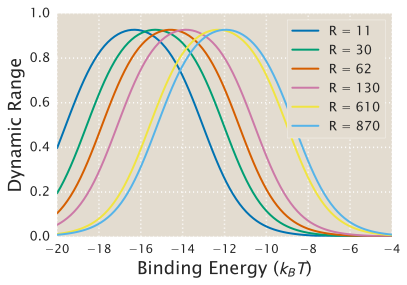

In [13]:
energies = np.linspace(-20, -4, 100)
Reps = np.array([11, 30, 62, 130, 610, 870])

for R in Reps:
    plt.plot(energies, dynamic_range(energies, R), label=('R = %i' % R))

plt.xlabel(r'Binding Energy ($k_BT$)')    
plt.ylabel(r'Dynamic Range')
plt.legend()

As we can see from this plot, all values of $R$ have the same maximum dynamic range, but the maximum occurs at different values of $\Delta \varepsilon_R$. This makes sense, as the maximum dynamic range should occur at an identical value for $\frac{R}{N_{NS}} e^{-\Delta \varepsilon_R}$ for each strain, and changes in $R$ and $\Delta \varepsilon_R$ compensate one another. We can see from this plot that the "ideal" binding energy for the wild type repressor copy number, $R=11$, occurs at approximately $-16.4~k_BT$. This is about $1~k_BT$ stronger than O1. 


Clearly, we should be able to solve for the maximum of the dynamic range equation and identify the ideal binding energy for each strain. I rewrite the equation for dynamic range in the form

\begin{equation}
\mathrm{dynamic\ range} = \left(1 + C_1 e^{-\Delta \varepsilon_R}\right)^{-1} - \left(1 + C_2 e^{-\Delta \varepsilon_R}\right)^{-1}
\end{equation}

where $C_1 = \frac{1}{1 + e^{-\Delta \varepsilon_{AI}}\left(\frac{K_A}{K_I}\right)^2} \frac{R}{N_{NS}}$ and $C_2 = \frac{1}{1 + e^{-\Delta \varepsilon_{AI}}} \frac{R}{N_{NS}}$. Then, the derivative of the dynamic range is equal to 

\begin{equation}
\frac{\partial}{\partial \varepsilon} = \varepsilon e^{-\varepsilon} \left(\frac{C_1}{\left(1 + C_1 e^{-\varepsilon}\right)^2} - \frac{C_2}{\left(1 + C_2 e^{-\varepsilon}\right)^2}\right),
\end{equation}

where for convenience I have written $\beta \Delta \varepsilon_R$ as simply $\varepsilon$. Setting the derivative equal to zero and then solving for $\varepsilon$ gives us $\Delta \varepsilon_\mathrm{R, ideal} = \frac{1}{2}\ln{C_1C_2}\ k_BT$. Substituting $C_1$ and $C_2$ back into the equation gives us

\begin{equation}
\Delta \varepsilon_\mathrm{R, ideal} = \frac{1}{2} \ln{\left[\left(\frac{R}{N_{NS}}\right)^2 \frac{1}{\left(1 + e^{-\beta \Delta \varepsilon_{AI}}\right)\left(1 + e^{-\beta \Delta \varepsilon_{AI}} \left(\frac{K_A}{K_I}\right)^2\right)}\right]}\ k_BT.
\end{equation}

This is plotted out below.

In [4]:
# Solve for ideal binding energy

def ideal_energy(R):
    e_AI = 4.5
    K_A = 141
    K_I = 0.56
    NNS = 5E6
    
    C1 = R/(NNS*(1 + np.exp(-e_AI)*(K_A/K_I)**2))
    C2 = R/(NNS*(1 + np.exp(-e_AI)))
    
    return 0.5*np.log(C1*C2)

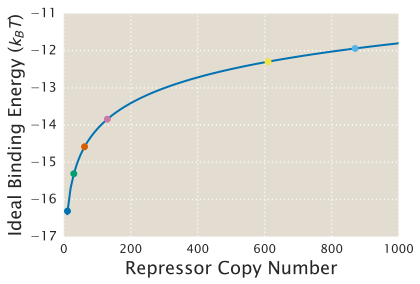

In [14]:
Reps = np.array([11, 30, 62, 130, 610, 870])
Reps_cont = np.linspace(0,1000,100)
plt.plot(Reps_cont, ideal_energy(Reps_cont))

i = 0
for R in Reps:
    plt.plot(R, ideal_energy(R), 'o', color = sns.color_palette()[i])
    i += 1
plt.xlabel('Repressor Copy Number')
plt.ylabel(r'Ideal Binding Energy ($k_BT$)')

We can use these ideas to identify binding energies where we might get stronger binding and a smaller dynamic range, as we see in Mitch Lewis' data for Q21M (Q18M for their version of LacI). Below we model the titration curve for wild-type O1 with $R=11$ and some hypothetical construct with a higher binding energy of $\Delta \varepsilon_R=-19~k_BT$. We see that this gives us similar behavior to what Mitch Lewis saw for Q21M. It binds more tightly than the wild type but has a significantly reduced dynamic range. We have a single data set for Q21M that uses our experimental setup, and the Q21M titration curve for O1 looks very similar to the hypothetical curve shown here for $\Delta \varepsilon_R=-19~k_BT$.

In [16]:
def fold_change(R, Op, c):
    e_AI = 4.5
    K_A = 141E-6
    K_I = 0.56E-6
    NNS = 5E6
    
    pA = (1 + c/K_A)**2/((1 + c/K_A)**2 + np.exp(-e_AI)*(1 + c/K_I)**2)
    return 1/(1 + pA*(R/NNS)*np.exp(-Op))

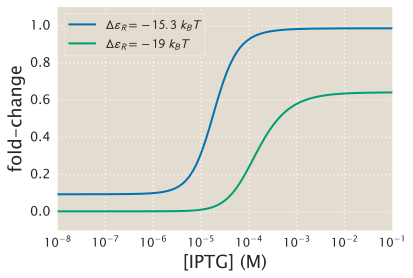

In [17]:
c = np.logspace(-8, -1, 100)
plt.semilogx(c, fold_change(11, -15.3, c), label=r'$\Delta \varepsilon_R = -15.3\ k_BT$')
plt.semilogx(c, fold_change(11, -19, c), label=r'$\Delta \varepsilon_R = -19\ k_BT$')
axes=plt.gca()
axes.set_ylim(-0.1, 1.1)

plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')